In [1]:
import pandas as pd
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
import seaborn as sns
from copy import deepcopy

import json 
import copy
import re 
pd.set_option('display.max_columns',100)
pd.set_option('display.max_colwidth',500)


## pointer
https://github.com/esantus/EVALution/blob/master/EVALution_1.0/RELATIONS.txt

# Relata info

In [2]:

pos_mapping={"j": 'ADJ', 'v': 'VERB', 'n': 'NOUN'}

def load_data_relata(orig_path = '../data/EVAL1.0/RELATA.txt'):
    '''
    read the original dataset and return dataframe 
    
    POS: 'term-dominatPOS' 
    forms: 'distribution-forms', e..g, absolute_95/Absolute_3/absolutes_1	
    POS-count: distribution-POS
    '''

    columns = ['relatum', 'tags', 'frequency', 'POS', 'POS_count_broad', 'forms', 'POS_count_fine']
    examples = []
    with open(orig_path, 'r') as fin:
        lines = fin.readlines()
        for line in lines:
            line_list = line.strip().split("\t")
            example = dict(zip(columns, line_list))
#             print(example['term-dominatPOS'].split('-'))
            example['POS'] = pos_mapping.get(example['POS'].split("-")[-1], 'UNK')
            example['forms'] = list(set([x.split('_')[0].lower() for x in example['forms'].split('/')]))
            example['frequency'] = int(example['frequency'])
#             reliable_tags = []
#             for x in example['tags'].split(","):
#                 for tag in x.split('/'):
#                     if len(tag)>1 and tag[-1]!=None:
#                         if int(tag[-1])>1:
#                             reliable_tags.append(tag) 
            
#             example['tags'] = ",".join(reliable_tags)

            examples.append(example)
    df = pd.DataFrame(examples)
    realtion_sets = set(df["POS"])
    print(Counter(df["POS"]).most_common())
    return df 

df_relata = load_data_relata(orig_path = '../data/EVAL1.0/RELATA.txt')
# df_ = df.query("relation == 'IsA'")
df_relata.head()

# word_to_freq = read_word_to_concreteness() #word_to_freq: freq is the medium of concreteness score 

[('NOUN', 1111), ('VERB', 343), ('ADJ', 234), ('UNK', 141)]


,relatum,tags,frequency,POS,POS_count_broad,forms,POS_count_fine
0,absolute,"SPECIFIC_1/2,CONCRETE_1/2,GENERAL_1/2",69877,ADJ,JJ_98/NN_1,"[absolute, absolutes]",JJ_98/NNS_1
1,abstract,"SUPERORDINATE_1/2,ABSTRACT_2/2,GENERAL_2/2,OTHER_1/2,SUBORDINATE_1/2,EVENT_1/2",92663,ADJ,JJ_68/NN_27/VV_4,"[abstract, abstracted, abstracts, abstracting]",JJ_68/NNS_20/NN_7/VVN_1/VVG_1
2,accident,"SUPERORDINATE_1/2,CONCRETE_1/2,EVENT_2/2,GENERAL_1/2",159563,NOUN,NN_99,"[accident, accidents]",NN_69/NNS_30
3,account,"SUPERORDINATE_2/2,ABSTRACT_2/2,OTHER_2/2,GENERAL_2/2",600523,NOUN,NN_87/VV_12,"[account, accounted, accounts, accounting]",NN_61/NNS_25/VV_3/VVP_2/VVZ_2/VVD_1/VVN_1/VVG_1
4,act,"SUPERORDINATE_4/26,PLANT_1/26,COLOR_1/26,SPACE_1/26,FOOD_1/26,PEOPLE_1/26,ABSTRACT_12/26,TIME_1/26,OBJECT_1/26,GENERAL_9/26,SPECIFIC_8/26,CONCRETE_5/26,OTHER_8/26,ANIMAL_1/26,BASIC_7/26,SUBORDINATE_4/26,EVENT_18/26",614927,VERB,VV_56/NN_43,"[act, acts, acted, acting]",NN_26/VVG_18/VV_18/NNS_16/VVZ_6/VVD_5/VVN_4/VVP_3


# Read the results and add conreteness info

In [3]:
dataset_to_respath={
    "hypernymsuite-BLESS": "log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv",
    "lm_diagnostic_extended-singular": "log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv",
    "clsb-singular": "log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.CLSB.csv",
    "hypernymsuite-LEDS": "log/bert-large-uncased/hypernymsuite/LEDS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv",
    "hypernymsuite-EVAL": "log/bert-large-uncased/hypernymsuite/EVAL/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv",
    "hypernymsuite-SHWARTZ": "log/bert-large-uncased/hypernymsuite/SHWARTZ/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv"}

def get_dataset_to_respath(dataset_to_respath, print_flag=False):
    # remote path 
#     dataset_to_respath = {'hypernymsuite-BLESS': 'log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'lm_diagnostic_extended-singular': 'log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv', 'clsb-singular': 'log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.CLSB.csv', 'hypernymsuite-LEDS': 'log/bert-large-uncased/hypernymsuite/LEDS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'hypernymsuite-EVAL': 'log/bert-large-uncased/hypernymsuite/EVAL/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'hypernymsuite-SHWARTZ': 'log/bert-large-uncased/hypernymsuite/SHWARTZ/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv'}

    source_dir = 'spartan:~/cogsci/DAP/'
    target_dir = '../../'
    dataset_to_localpath = defaultdict()
    dataset_rename = {
        'hypernymsuite-BLESS': 'BLESS', 'lm_diagnostic_extended-singular': 'DIAG', 'clsb-singular':'CLSB', 'hypernymsuite-LEDS': 'LEDS', 'hypernymsuite-EVAL': 'EVAL', 'hypernymsuite-SHWARTZ': 
        "SHWARTZ"
    }
    for dataset, path in dataset_to_respath.items():
        path = path.replace(".tsv", ".csv")
        source_path = source_dir + path 
        dataset_l1 = dataset.split("-")[0]
        dataset_l2 = dataset.split("-")[1] 
        target_path = target_dir + path
        scp_string = f"!scp {source_path} {target_path}"
        if print_flag:
            print(scp_string)
            print()
#         print(target_path)
        dataset_to_localpath[dataset_rename[dataset]] = target_path 
#     print(dataset_to_localpath)
    return dataset_to_localpath
dataset_to_localpath = get_dataset_to_respath(dataset_to_respath)
# dataset_to_localpath

In [4]:
df = pd.read_csv(dataset_to_localpath['EVAL'])

In [5]:

df_relata['POS_count_broad_num'] = df_relata['POS_count_broad'].apply(lambda x: len(x.split("/")))
df_relata['tags_num'] = df_relata['tags'].apply(lambda x: len(x.split(",")))
word_to_pos_num = dict(zip(df_relata['relatum'], df_relata['POS_count_broad_num']))
word_to_tags_num = dict(zip(df_relata['relatum'], df_relata['tags_num']))
word_to_pos_count = dict(zip(df_relata['relatum'], df_relata['POS_count_broad']))

df['sub_POS_count_broad'] = df['sub_label_sg'].apply(lambda x: word_to_pos_count.get(x) )
df['obj_POS_count_broad'] = df['obj_label'].apply(lambda x: word_to_pos_count.get(eval(x)[0]) )


In [51]:
# df_relata.head()[['relatum', 'tags']]
# df['sub_label_sg'].head()

,relatum,tags
0,absolute,"SPECIFIC_1/2,CONCRETE_1/2,GENERAL_1/2"
1,abstract,"SUPERORDINATE_1/2,ABSTRACT_2/2,GENERAL_2/2,OTHER_1/2,SUBORDINATE_1/2,EVENT_1/2"
2,accident,"SUPERORDINATE_1/2,CONCRETE_1/2,EVENT_2/2,GENERAL_1/2"
3,account,"SUPERORDINATE_2/2,ABSTRACT_2/2,OTHER_2/2,GENERAL_2/2"
4,act,"SUPERORDINATE_4/26,PLANT_1/26,COLOR_1/26,SPACE_1/26,FOOD_1/26,PEOPLE_1/26,ABSTRACT_12/26,TIME_1/26,OBJECT_1/26,GENERAL_9/26,SPECIFIC_8/26,CONCRETE_5/26,OTHER_8/26,ANIMAL_1/26,BASIC_7/26,SUBORDINATE_4/26,EVENT_18/26"


In [13]:
display(df_relata.query("relatum=='age'"))
display(df_relata.query("relatum=='change'"))

,relatum,tags,frequency,POS,POS_count_broad,forms,POS_count_fine,POS_count_broad_num,tags_num
21,age,"CONCRETE_1/2,ABSTRACT_1/2,TIME_1/2,GENERAL_1/2",1130840,NOUN,NN_83/VV_16,"[ages, age, aged, ageing]",NN_75/VVN_13/NNS_8/VVG_2,2,4


,relatum,tags,frequency,POS,POS_count_broad,forms,POS_count_fine,POS_count_broad_num,tags_num
259,change,"ABSTRACT_1/2,BASIC_1/2,EVENT_2/2,GENERAL_2/2",1771619,NOUN,NN_53/VV_46,"[change, changed, changes, changing]",NN_27/NNS_26/VV_16/VVN_11/VVG_10/VVD_5/VVP_1/VVZ_1,2,4


In [6]:

df['sub_pos_num'] = df['sub_label_sg'].apply(lambda x: word_to_pos_num.get(x))
df['obj_pos_num'] = df['obj_label_sg'].apply(lambda x: word_to_pos_num.get(eval(x)[0]))
df['sub_tags_num'] = df['sub_label_sg'].apply(lambda x: word_to_tags_num.get(x))
df['obj_tags_num'] = df['obj_label_sg'].apply(lambda x: word_to_tags_num.get(eval(x)[0]))

print(df['sub_pos_num'].value_counts(normalize=True))
print(df['obj_pos_num'].value_counts(normalize=True))
print(df['sub_tags_num'].value_counts(normalize=True))
print(df['obj_tags_num'].value_counts(normalize=True))

1    0.494229
2    0.471144
3    0.032529
5    0.001049
4    0.001049
Name: sub_pos_num, dtype: float64
1    0.568730
2    0.401889
3    0.029381
Name: obj_pos_num, dtype: float64
5     0.271773
4     0.251836
6     0.137461
16    0.084995
7     0.073452
2     0.056663
17    0.044071
1     0.036726
3     0.027282
8     0.008395
11    0.003148
12    0.002099
9     0.001049
15    0.001049
Name: sub_tags_num, dtype: float64
4     0.346275
6     0.214061
5     0.192025
16    0.074502
2     0.050367
17    0.043022
7     0.035677
3     0.025184
1     0.011542
8     0.005247
11    0.002099
Name: obj_tags_num, dtype: float64


In [20]:
display( df[['sub_pos_num', 'obj_pos_num']].value_counts(normalize=False) ) 
dfx = df.query("sub_pos_num==1 and obj_pos_num==1")

from significance_test import significance_test_single_dataset
metric_pairs = [ ['p10_def_sap', 'p10_lsp_sap'], ['p10_def_sap', 'p10_def_dap'], ['p10_lsp_sap', 'p10_lsp_dap']]
ttest = significance_test_single_dataset(dfx, dataset='EVAL-NOUNNOUN', metrics=metric_pairs, min_pvalue =0.05, display_res=False)
print(ttest)

print(len(dfx.index))
metrics = [ 'p10_def_sap', 'p10_def_dap', 'p10_lsp_sap', 'p10_lsp_dap']
display(dfx[metrics].mean().to_frame().T)
display(df[metrics].mean().to_frame().T)
dfx[['sub_label_sg', 'obj_label', 'sub_POS_count_broad','obj_POS_count_broad', 'obj_mask_def_sap', 'obj_mask_lsp_sap', 'p10_def_sap', 'p10_lsp_sap']].query("p10_def_sap==1 and p10_lsp_sap==0").sample(50)
# .sample(20)

sub_pos_num  obj_pos_num
1            1              288
2            1              233
             2              203
1            2              169
dtype: int64

                        metric        dataset  statistic        pvalue  \
0  p10_def_sap .vs p10_lsp_sap  EVAL-NOUNNOUN   5.570191  5.854745e-08   
1  p10_def_sap .vs p10_def_dap  EVAL-NOUNNOUN  -1.121398  2.630558e-01   
2  p10_lsp_sap .vs p10_lsp_dap  EVAL-NOUNNOUN  -1.815584  7.047770e-02   

   significantly different  
0                     True  
1                    False  
2                    False  
288


,p10_def_sap,p10_def_dap,p10_lsp_sap,p10_lsp_dap
0,0.552083,0.576389,0.385417,0.423611


,p10_def_sap,p10_def_dap,p10_lsp_sap,p10_lsp_dap
0,0.473684,0.466965,0.395297,0.399776


,sub_label_sg,obj_label,sub_POS_count_broad,obj_POS_count_broad,obj_mask_def_sap,obj_mask_lsp_sap,p10_def_sap,p10_lsp_sap
175,choice,['action'],NN_99,NN_99,"['decision', 'action', 'mistake', 'judgment', 'possibility', 'freedom', 'argument', 'change', 'rule', 'option']","['thing', 'option', 'yes', 'concept', 'possibility', 'issue', 'decision', 'consideration', 'factor', 'idea']",1,0
335,farmland,['country'],NN_100,NN_99,"['land', 'farm', 'field', 'forest', 'landscape', 'country', 'property', 'village', 'garden', 'pasture']","['land', 'area', 'agriculture', 'countryside', 'place', 'field', 'habitat', 'thing', 'landscape', 'use']",1,0
934,wine,['alcohol'],NN_99,NN_100,"['drink', 'beverage', 'beer', 'alcohol', 'liquor', 'food', 'bottle', 'liquid', 'fruit', 'product']","['product', 'food', 'beverage', 'thing', 'drink', 'good', 'dish', 'spirit', 'fruit', 'ingredient']",1,0
587,monk,['person'],NN_99,NN_100,"['priest', 'man', 'warrior', 'person', 'cleric', 'buddhist', 'saint', 'hermit', 'shaman', 'musician']","['people', 'clergy', 'religious', 'priest', 'christian', 'nun', 'man', 'foreigner', 'writer', 'woman']",1,0
853,television,['tv'],NN_100,NN_100,"['tv', 'computer', 'machine', 'radio', 'device', 'camera', 'thing', 'cinema', 'telephone', 'home']","['electronics', 'medium', 'device', 'equipment', 'thing', 'computer', 'technology', 'appliance', 'item', 'communication']",1,0
682,priest,['person'],NN_99,NN_100,"['man', 'cleric', 'person', 'monk', 'leader', 'bishop', 'minister', 'prophet', 'clergyman', 'servant']","['people', 'clergy', 'thing', 'official', 'man', 'monk', 'religious', 'woman', 'individual', 'elder']",1,0
139,capital,['city'],NN_99,NN_99,"['city', 'currency', 'building', 'town', 'province', 'municipality', 'letter', 'state', 'village', 'county']","['letter', 'symbol', 'shape', 'thing', 'character', 'word', 'form', 'feature', 'type', 'element']",1,0
819,statue,['image'],NN_99,NN_99,"['sculpture', 'monument', 'object', 'symbol', 'building', 'thing', 'artwork', 'god', 'image', 'painting']","['object', 'thing', 'monument', 'sculpture', 'structure', 'building', 'art', 'item', 'work', 'furniture']",1,0
620,organ,['instrument'],NN_100,NN_99,"['instrument', 'piano', 'synthesizer', 'harpsichord', 'church', 'voice', 'building', 'machine', 'keyboard', 'guitar']","['structure', 'thing', 'part', 'tissue', 'body', 'object', 'material', 'animal', 'item', 'fluid']",1,0
670,politician,['leader'],NN_99,NN_100,"['leader', 'person', 'lawyer', 'man', 'businessman', 'soldier', 'journalist', 'democrat', 'writer', 'official']","['people', 'celebrity', 'professional', 'individual', 'official', 'person', 'figure', 'dignitary', 'businessman', 'man']",1,0


In [23]:
from inflection import singularize, pluralize
print(singularize('people'))
print(pluralize('person'))

people
persons


In [8]:
dfx['sub_pos'] = dfx['sub_POS_count_broad'].apply(lambda x: x.split("_")[0])
dfx['obj_pos'] = dfx['obj_POS_count_broad'].apply(lambda x: x.split("_")[0])

print(Counter(dfx['sub_pos']).most_common())
print(Counter(dfx['obj_pos']).most_common())

[('NN', 288)]
[('NN', 288)]


<ipython-input-8-a63d9ce23edc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx['sub_pos'] = dfx['sub_POS_count_broad'].apply(lambda x: x.split("_")[0])
<ipython-input-8-a63d9ce23edc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx['obj_pos'] = dfx['obj_POS_count_broad'].apply(lambda x: x.split("_")[0])


In [9]:
dft = df.query("sub_pos_num==2 and obj_pos_num==2")[['sub_label_sg', 'obj_label', 'sub_POS_count_broad', 'obj_POS_count_broad']].sample(50)
def calcualte_pos_num_gap(text):
    '''
    text = NN_75/VV_24
    '''
    pos1, pos2 = text.split("/")
    num_gap = int(pos1.split("_")[1]) - int(pos2.split("_")[1])
    return num_gap 

dft['sub_pos_num_gap'] = dft['sub_POS_count_broad'].apply(lambda x: calcualte_pos_num_gap(x))
dft['obj_pos_num_gap'] = dft['obj_POS_count_broad'].apply(lambda x: calcualte_pos_num_gap(x))
dft.sort_values(by=['sub_pos_num_gap', 'obj_pos_num_gap'], ascending=True)[['sub_label_sg', 'obj_label', 
                                                           'sub_POS_count_broad', 'obj_POS_count_broad', 
                                                           'sub_pos_num_gap', 'obj_pos_num_gap']]


,sub_label_sg,obj_label,sub_POS_count_broad,obj_POS_count_broad,sub_pos_num_gap,obj_pos_num_gap
544,love,['care'],NN_50/VV_49,NN_82/VV_17,1,65
841,surprise,['change'],NN_55/VV_44,NN_53/VV_46,11,7
113,bowl,['sport'],NN_58/VV_41,NN_92/VV_7,17,85
234,crash,['change'],NN_60/VV_39,NN_53/VV_46,21,7
714,report,['document'],NN_62/VV_37,NN_89/VV_10,25,79
522,lease,['contract'],NN_64/VV_35,NN_90/VV_9,29,81
438,hem,['edge'],NN_67/VV_32,NN_93/VV_6,35,87
814,star,['shape'],NN_67/VV_31,NN_66/VV_33,36,33
320,exercise,['train'],NN_68/VV_31,NN_59/VV_40,37,19
211,control,['test'],NN_70/VV_29,NN_70/VV_29,41,41


<ipython-input-10-bde799e1ab29>:3: FutureWarning: ['sub_label', 'obj_label', 'relation', 'masked_sentences', 'sub_sister', 'sub_label_sg', 'sub_label_pl', 'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap', 'anchor_lsp_sap', 'sub_label_sgpl', 'obj_mask_sentence', 'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score', 'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors', 'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl', 'anchor_col_all', 'subj_anchors_combined', 'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor', 'lsp_dap_with_subj_anchor', 'obj_mask_def_dap', 'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score', 'anchor_wordnet_path_len', 'obj_label_sg', 'sub_POS_count_broad', 'obj_POS_count_broad'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_group = df.groupby(['obj_pos_num']).agg(['mean']) #, 'obj_pos_num'


,p10_def_sap,p10_def_dap,p10_lsp_sap,p10_lsp_dap
,mean,mean,mean,mean
obj_pos_num,,,,
1,0.495202,0.531670,0.362764,0.397313
2,0.443548,0.376344,0.440860,0.403226
3,0.444444,0.333333,0.370370,0.296296


                        metric        dataset  statistic    pvalue  \
0  p10_def_sap .vs p10_lsp_sap  EVAL-NOUNNOUN   4.914951  0.000001   
1  p10_def_sap .vs p10_def_dap  EVAL-NOUNNOUN   0.804830  0.421126   
2  p10_lsp_sap .vs p10_lsp_dap  EVAL-NOUNNOUN  -0.204018  0.838385   

   significantly different  
0                     True  
1                    False  
2                    False  


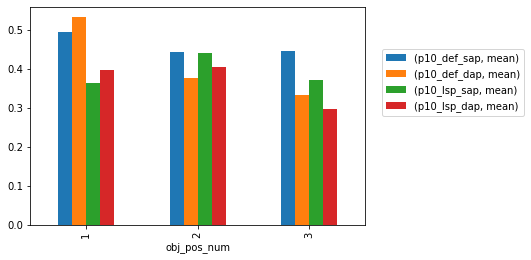

In [10]:
metrics = [ 'p10_def_sap', 'p10_def_dap', 'p10_lsp_sap', 'p10_lsp_dap']
df = df.query("sub_pos_num<3")
df_group = df.groupby(['obj_pos_num']).agg(['mean']) #, 'obj_pos_num'
display(df_group[metrics])
display(df_group[metrics].plot(kind='bar'))
plt.legend(loc=(1.05,0.5))

from significance_test import significance_test_single_dataset
metric_pairs = [ ['p10_def_sap', 'p10_lsp_sap'], ['p10_def_sap', 'p10_def_dap'], ['p10_lsp_sap', 'p10_lsp_dap']]
ttest = significance_test_single_dataset(df, dataset='EVAL-NOUNNOUN', metrics=metric_pairs, min_pvalue =0.05, display_res=False)
print(ttest)



<ipython-input-14-3262ecbe1388>:3: FutureWarning: ['sub_label', 'obj_label', 'relation', 'masked_sentences', 'sub_sister', 'sub_label_sg', 'sub_label_pl', 'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap', 'anchor_lsp_sap', 'sub_label_sgpl', 'obj_mask_sentence', 'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score', 'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors', 'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl', 'anchor_col_all', 'subj_anchors_combined', 'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor', 'lsp_dap_with_subj_anchor', 'obj_mask_def_dap', 'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score', 'anchor_wordnet_path_len', 'obj_label_sg', 'sub_POS_count_broad', 'obj_POS_count_broad'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_group = df.groupby(['sub_pos_num', 'obj_pos_num']).agg(['mean']) #, 'obj_pos_nu

p10_def_sap p10_def_dap p10_lsp_sap p10_lsp_dap
                               mean        mean        mean        mean
sub_pos_num obj_pos_num                                                
1           1              0.552083    0.576389    0.385417    0.423611
            2              0.437870    0.360947    0.491124    0.461538
2           1              0.424893    0.476395    0.334764    0.364807
            2              0.448276    0.389163    0.399015    0.354680

sub_pos_num  obj_pos_num
1            1              288
2            1              233
             2              203
1            2              169
dtype: int64


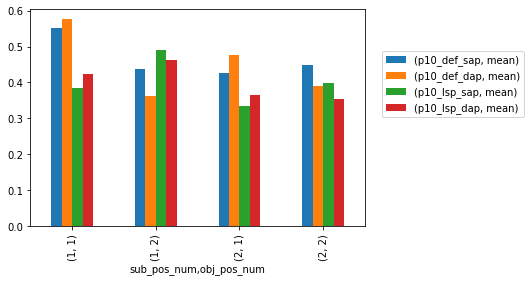

In [14]:
metrics = [ 'p10_def_sap', 'p10_def_dap', 'p10_lsp_sap', 'p10_lsp_dap']
df = df.query("obj_pos_num<=2")
df_group = df.groupby(['sub_pos_num', 'obj_pos_num']).agg(['mean']) #, 'obj_pos_num'
display(df_group[metrics])
display(df_group[metrics].plot(kind='bar'))
plt.legend(loc=(1.05,0.5))
print(df[['sub_pos_num', 'obj_pos_num']].value_counts())

In [50]:
df.query("sub_label == 'contacts'")[['sub_label', 'sub_label_sg', 'obj_label', 'obj_mask_def_sap', 'obj_mask_lsp_sap', 'obj_mask_def_dap', 'obj_mask_lsp_dap']]

,sub_label,sub_label_sg,obj_label,obj_mask_def_sap,obj_mask_lsp_sap,obj_mask_def_dap,obj_mask_lsp_dap
206,contacts,contact,['lens'],"['relationship', 'connection', 'communication', 'object', 'touch', 'interaction', 'contract', 'thing', 'sign', 'message']","['thing', 'information', 'friend', 'acquaintance', 'connection', 'relationship', 'yes', 'detail', 'source', 'relative']","['person', 'relationship', 'communication', 'meeting', 'link', 'connection', 'friend', 'agent', 'information', 'organization']","['information', 'thing', 'acquaintance', 'friend', 'people', 'associate', 'relative', 'employee', 'communication', 'agent']"
207,contacts,contact,['touch'],"['relationship', 'connection', 'communication', 'object', 'touch', 'interaction', 'contract', 'thing', 'sign', 'message']","['thing', 'information', 'friend', 'acquaintance', 'connection', 'relationship', 'yes', 'detail', 'source', 'relative']","['person', 'relationship', 'communication', 'meeting', 'link', 'connection', 'friend', 'agent', 'information', 'organization']","['information', 'thing', 'acquaintance', 'friend', 'people', 'associate', 'relative', 'employee', 'communication', 'agent']"


<ipython-input-36-33d47f9eb372>:3: FutureWarning: ['sub_label', 'obj_label', 'relation', 'masked_sentences', 'sub_sister', 'sub_label_sg', 'sub_label_pl', 'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap', 'anchor_lsp_sap', 'sub_label_sgpl', 'obj_mask_sentence', 'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score', 'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors', 'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl', 'anchor_col_all', 'subj_anchors_combined', 'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor', 'lsp_dap_with_subj_anchor', 'obj_mask_def_dap', 'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score', 'anchor_wordnet_path_len', 'obj_label_sg'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_group = df.groupby(['obj_pos_num']).agg(['mean'])


,p10_def_sap,p10_def_dap,p10_lsp_sap,p10_lsp_dap
,mean,mean,mean,mean
obj_pos_num,,,,
1,0.495202,0.531670,0.362764,0.397313
2,0.443548,0.376344,0.440860,0.403226


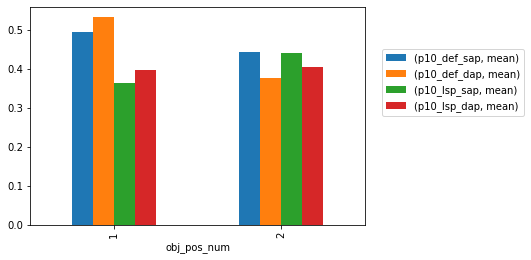

In [36]:
metrics = [ 'p10_def_sap', 'p10_def_dap', 'p10_lsp_sap', 'p10_lsp_dap']
df = df.query("obj_pos_num<3")
df_group = df.groupby(['obj_pos_num']).agg(['mean'])
display(df_group[metrics])
display(df_group[metrics].plot(kind='bar'))
plt.legend(loc=(1.05,0.5))

<ipython-input-46-67a94b444d72>:3: FutureWarning: ['sub_label', 'obj_label', 'relation', 'masked_sentences', 'sub_sister', 'sub_label_sg', 'sub_label_pl', 'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap', 'anchor_lsp_sap', 'sub_label_sgpl', 'obj_mask_sentence', 'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score', 'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors', 'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl', 'anchor_col_all', 'subj_anchors_combined', 'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor', 'lsp_dap_with_subj_anchor', 'obj_mask_def_dap', 'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score', 'anchor_wordnet_path_len', 'obj_label_sg'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_group = df.groupby(['sub_tags_num']).agg(['mean'])


,p10_def_sap,p10_def_dap,p10_lsp_sap,p10_lsp_dap
,mean,mean,mean,mean
sub_tags_num,,,,
1,0.294118,0.352941,0.235294,0.205882
2,0.551020,0.428571,0.489796,0.367347
3,0.320000,0.400000,0.400000,0.320000
4,0.495536,0.495536,0.406250,0.419643
5,0.481633,0.457143,0.391837,0.400000
6,0.418033,0.426230,0.393443,0.426230
7,0.564516,0.532258,0.435484,0.419355
8,0.750000,0.750000,0.500000,0.500000


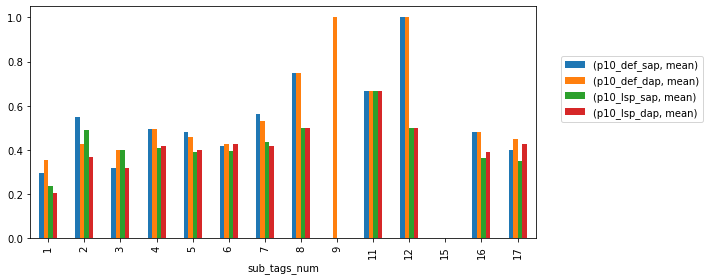

In [46]:
metrics = [ 'p10_def_sap', 'p10_def_dap', 'p10_lsp_sap', 'p10_lsp_dap']
# df = df.query("sub_pos_num<3")
df_group = df.groupby(['sub_tags_num']).agg(['mean'])
display(df_group[metrics])
display(df_group[metrics].plot(kind='bar', figsize=(10,4)))
plt.legend(loc=(1.05,0.5))
plt.tight_layout()
plt.savefig('../log/paper_results/analysis/eval_tags_num_sub.pdf')
plt.show()

<ipython-input-47-c225945c583a>:3: FutureWarning: ['sub_label', 'obj_label', 'relation', 'masked_sentences', 'sub_sister', 'sub_label_sg', 'sub_label_pl', 'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap', 'anchor_lsp_sap', 'sub_label_sgpl', 'obj_mask_sentence', 'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score', 'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors', 'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl', 'anchor_col_all', 'subj_anchors_combined', 'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor', 'lsp_dap_with_subj_anchor', 'obj_mask_def_dap', 'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score', 'anchor_wordnet_path_len', 'obj_label_sg'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df_group = df.groupby(['obj_tags_num']).agg(['mean'])


,p10_def_sap,p10_def_dap,p10_lsp_sap,p10_lsp_dap
,mean,mean,mean,mean
obj_tags_num,,,,
1,0.727273,0.454545,0.454545,0.363636
2,0.234043,0.319149,0.127660,0.148936
3,0.476190,0.380952,0.285714,0.285714
4,0.580128,0.625000,0.423077,0.455128
5,0.373494,0.379518,0.337349,0.319277
6,0.474747,0.373737,0.494949,0.489899
7,0.366667,0.433333,0.433333,0.400000
8,0.200000,0.200000,0.400000,0.400000


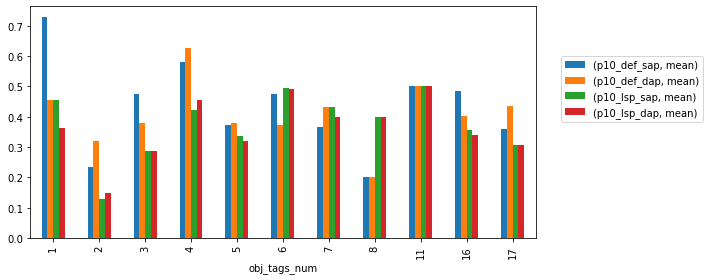

In [47]:
metrics = [ 'p10_def_sap', 'p10_def_dap', 'p10_lsp_sap', 'p10_lsp_dap']
# df = df.query("sub_pos_num<3")
df_group = df.groupby(['obj_tags_num']).agg(['mean'])
display(df_group[metrics])
display(df_group[metrics].plot(kind='bar', figsize=(10,4)))
plt.legend(loc=(1.05,0.5))
plt.tight_layout()
plt.savefig('../log/paper_results/analysis/eval_tags_num_obj.pdf')
plt.show()

In [77]:
dataset_to_df = defaultdict()
shared = ['insect', 'cattle', 'furniture', 'fruit', 'vessel', 'container', 'pet', 'game', 'device', 'bird', 'animal', 'vehicle', 'home', 'grain', 'weapon', 'mammal', 'food', 'construction', 'boat', 'tree', 'vegetable', 'instrument', 'tool', 'house', 'object', 'plant']

for dataset, path in dataset_to_localpath.items(): 
#     if dataset!='EVAL': continue 
    df = pd.read_csv(path)
    df['obj_label'] = df['obj_label'].apply(lambda x: eval(x)[0])
    df = df.query(f'obj_label in {shared}')
    dataset_to_df[dataset] = df 
        

In [76]:
# dataset_to_df['EVAL']['obj_label'] = dataset_to_df['EVAL']['obj_label'].apply(lambda x: eval(x)[0])
# dataset_to_df['BLESS']['obj_label'] = dataset_to_df['BLESS']['obj_label'].apply(lambda x: eval(x)[0])

set1 = set(dataset_to_df['EVAL']['obj_label'])
set2 = set(dataset_to_df['BLESS']['obj_label'])

shared= list(set1.intersection(set2))
print("shared,", len(shared))
print(shared)

shared, 26
['insect', 'cattle', 'furniture', 'fruit', 'vessel', 'container', 'pet', 'game', 'device', 'bird', 'animal', 'vehicle', 'home', 'grain', 'weapon', 'mammal', 'food', 'construction', 'boat', 'tree', 'vegetable', 'instrument', 'tool', 'house', 'object', 'plant']


In [81]:
# dataset_to_df['EVAL']
metrics = [ 'p10_def_sap', 'p10_def_dap', 'p10_lsp_sap', 'p10_lsp_dap']
for dataset, df in dataset_to_df.items():
    print(dataset, df[metrics].mean().to_frame().T)
    print()

BLESS    p10_def_sap  p10_def_dap  p10_lsp_sap  p10_lsp_dap
0     0.634804     0.676471     0.730392     0.730392

DIAG    p10_def_sap  p10_def_dap  p10_lsp_sap  p10_lsp_dap
0     0.639687     0.744125     0.681462     0.762402

CLSB    p10_def_sap  p10_def_dap  p10_lsp_sap  p10_lsp_dap
0     0.816638     0.855688     0.874363     0.874363

LEDS    p10_def_sap  p10_def_dap  p10_lsp_sap  p10_lsp_dap
0     0.844262     0.872951     0.815574     0.852459

EVAL    p10_def_sap  p10_def_dap  p10_lsp_sap  p10_lsp_dap
0     0.666667     0.679487     0.596154     0.589744

SHWARTZ    p10_def_sap  p10_def_dap  p10_lsp_sap  p10_lsp_dap
0     0.652174     0.637681     0.608696     0.637681



In [104]:
dataset_to_df['EVAL']['dataset'] = 'EVAL'
dataset_to_df['BLESS']['dataset'] = 'BLESS'
# food, device, object 

stats = []
df3 = pd.concat([dataset_to_df['EVAL'], dataset_to_df['BLESS']], axis=0)
query_cols = ['sub_label_sg', 'obj_label', 'dataset', 'p10_def_sap', 'p10_def_dap', 'p10_lsp_sap', 'p10_lsp_dap']
for name, group in df3.groupby(['obj_label']):
#     display(group[['sub_label_sg', 'obj_label', 'dataset', 'p10_def_sap', 'p10_def_dap', 'p10_lsp_sap', 'p10_lsp_dap']].sample(50))
    print(name, len(group.index))
    groupe = group.query("dataset=='EVAL'")[query_cols].mean()
    groupb = group.query("dataset=='BLESS'")[query_cols].mean()
    display(groupe)
    display(groupb)

    #     display(group.query("dataset=='EVAL' and p10_def_sap==1")[query_cols])
#     display(group.query("dataset=='BLESS' and p10_lsp_sap==1")[query_cols])

animal 81


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    1.000000
p10_def_dap    1.000000
p10_lsp_sap    0.952381
p10_lsp_dap    0.952381
dtype: float64

p10_def_sap    0.900000
p10_def_dap    0.866667
p10_lsp_sap    0.966667
p10_lsp_dap    0.966667
dtype: float64

bird 17


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    1.0
p10_def_dap    0.5
p10_lsp_sap    1.0
p10_lsp_dap    0.5
dtype: float64

p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

boat 4


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.5
p10_def_dap    0.5
p10_lsp_sap    0.5
p10_lsp_dap    0.5
dtype: float64

p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

cattle 2


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.0
p10_def_dap    0.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

construction 10


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.0
p10_def_dap    0.0
p10_lsp_sap    0.0
p10_lsp_dap    0.0
dtype: float64

p10_def_sap    0.000000
p10_def_dap    0.000000
p10_lsp_sap    0.000000
p10_lsp_dap    0.111111
dtype: float64

container 13


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.500000
p10_def_dap    0.666667
p10_lsp_sap    0.166667
p10_lsp_dap    0.500000
dtype: float64

p10_def_sap    1.000000
p10_def_dap    1.000000
p10_lsp_sap    0.857143
p10_lsp_dap    1.000000
dtype: float64

device 44


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.583333
p10_def_dap    0.583333
p10_lsp_sap    0.500000
p10_lsp_dap    0.500000
dtype: float64

p10_def_sap    0.21875
p10_def_dap    0.34375
p10_lsp_sap    0.37500
p10_lsp_dap    0.40625
dtype: float64

food 69


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.730769
p10_def_dap    0.769231
p10_lsp_sap    0.653846
p10_lsp_dap    0.692308
dtype: float64

p10_def_sap    0.232558
p10_def_dap    0.534884
p10_lsp_sap    0.581395
p10_lsp_dap    0.581395
dtype: float64

fruit 17


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

furniture 13


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.666667
p10_def_dap    0.666667
p10_lsp_sap    0.666667
p10_lsp_dap    0.666667
dtype: float64

p10_def_sap    0.9
p10_def_dap    0.9
p10_lsp_sap    1.0
p10_lsp_dap    0.9
dtype: float64

game 16


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.466667
p10_def_dap    0.533333
p10_lsp_sap    0.533333
p10_lsp_dap    0.466667
dtype: float64

p10_def_sap    0.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

grain 2


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

home 5


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    0.0
p10_lsp_dap    0.0
dtype: float64

p10_def_sap    0.666667
p10_def_dap    0.666667
p10_lsp_sap    0.000000
p10_lsp_dap    0.333333
dtype: float64

house 6


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

p10_def_sap    1.000000
p10_def_dap    1.000000
p10_lsp_sap    0.666667
p10_lsp_dap    0.666667
dtype: float64

insect 10


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.5
p10_def_dap    0.5
p10_lsp_sap    0.5
p10_lsp_dap    0.5
dtype: float64

p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

instrument 12


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.75
p10_def_dap    0.75
p10_lsp_sap    0.50
p10_lsp_dap    0.50
dtype: float64

p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

mammal 29


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.666667
p10_def_dap    0.500000
p10_lsp_sap    0.333333
p10_lsp_dap    0.500000
dtype: float64

p10_def_sap    0.913043
p10_def_dap    1.000000
p10_lsp_sap    0.956522
p10_lsp_dap    0.956522
dtype: float64

object 84


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.538462
p10_def_dap    0.615385
p10_lsp_sap    0.692308
p10_lsp_dap    0.538462
dtype: float64

p10_def_sap    0.140845
p10_def_dap    0.126761
p10_lsp_sap    0.338028
p10_lsp_dap    0.309859
dtype: float64

pet 6


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.5
p10_def_dap    0.5
p10_lsp_sap    0.5
p10_lsp_dap    0.5
dtype: float64

p10_def_sap    0.00
p10_def_dap    0.25
p10_lsp_sap    0.50
p10_lsp_dap    0.50
dtype: float64

plant 17


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    1.000
p10_def_dap    1.000
p10_lsp_sap    0.625
p10_lsp_dap    0.500
dtype: float64

p10_def_sap    0.777778
p10_def_dap    0.777778
p10_lsp_sap    1.000000
p10_lsp_dap    1.000000
dtype: float64

tool 28


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.384615
p10_def_dap    0.307692
p10_lsp_sap    0.461538
p10_lsp_dap    0.461538
dtype: float64

p10_def_sap    1.000000
p10_def_dap    1.000000
p10_lsp_sap    0.933333
p10_lsp_dap    0.866667
dtype: float64

tree 11


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.5
p10_def_dap    0.5
p10_lsp_sap    0.5
p10_lsp_dap    0.0
dtype: float64

p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

vegetable 17


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.0
p10_def_dap    0.0
p10_lsp_sap    0.0
p10_lsp_dap    0.0
dtype: float64

p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

vehicle 20


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64

p10_def_sap    0.789474
p10_def_dap    0.736842
p10_lsp_sap    0.789474
p10_lsp_dap    0.789474
dtype: float64

vessel 13


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.75
p10_def_dap    0.75
p10_lsp_sap    0.25
p10_lsp_dap    0.25
dtype: float64

p10_def_sap    1.000000
p10_def_dap    1.000000
p10_lsp_sap    0.888889
p10_lsp_dap    0.888889
dtype: float64

weapon 18


<ipython-input-104-077d9ff465e2>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupe = group.query("dataset=='EVAL'")[query_cols].mean()
<ipython-input-104-077d9ff465e2>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  groupb = group.query("dataset=='BLESS'")[query_cols].mean()


p10_def_sap    0.333333
p10_def_dap    0.333333
p10_lsp_sap    0.000000
p10_lsp_dap    0.333333
dtype: float64

p10_def_sap    1.0
p10_def_dap    1.0
p10_lsp_sap    1.0
p10_lsp_dap    1.0
dtype: float64